In [1]:
# Suppress warnings
import warnings
from pathlib import Path

import floris.layout_visualization as layoutviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from floris import FlorisModel

import flasc.model_fitting.floris_tuning as ft

# from flasc.model_tuning.floris_tuner import FlorisTuner
import flasc.utilities.floris_tools as ftools

warnings.filterwarnings("ignore")

# Parameters

In [2]:
model_to_tune_to = "emgauss"  # gch, turbopark, emgauss
n_row_x = 3  # Define the number of turbine rows in the x direction
n_row_y = 3  # Define the number of turbine rows in the y direction (should be odd)
D_between_turbines_x = 7  # Distance between turbines
D_between_turbines_y = 10  # Distance between turbines

if n_row_y % 2 == 0:
    warnings.warn("Even number will be weird")

In [3]:
# Parameters about timing and grouping
points_per_group = 10

## Load FLORIS

In [4]:
# Load the FLORIS models for GCH and EMG
file_path = Path.cwd()

# Load the model to tune to (fi_benchmark)
fm_path = file_path / f"../floris_input_artificial/{model_to_tune_to}.yaml"
fm_benchmark = FlorisModel(fm_path)

# Load the emgauss model
fm_path = file_path / "../floris_input_artificial/emgauss.yaml"
fm_emg = FlorisModel(fm_path)

# Generate data to tune to

In [5]:
# Define a layout of num_turbines turbines arranged in a grid
num_turbines = n_row_x * n_row_y
D = 126

layout_x = []
layout_y = []

for i in range(n_row_x):
    for j in range(n_row_y):
        layout_x.append(i * D * D_between_turbines_x)
        layout_y.append(j * D * D_between_turbines_y)


print(layout_x)
print(layout_y)

[0, 0, 0, 882, 882, 882, 1764, 1764, 1764]
[0, 1260, 2520, 0, 1260, 2520, 0, 1260, 2520]


In [6]:
# Identify the indexes of the reference turbine, the control turbine,
# the single_wake turbine and the deep_wake turbine
ref_idx = 0
control_idx = int(np.floor(n_row_y / 2))
single_wake_idx = int(np.floor(n_row_y / 2) + n_row_y)
deep_wake_idx = int(num_turbines - (np.floor(n_row_y / 2)) - 1)

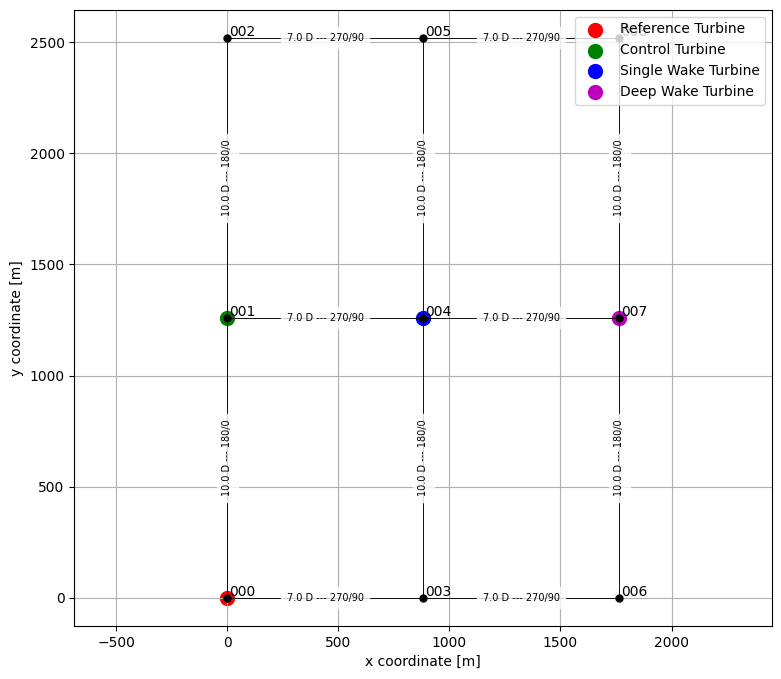

In [7]:
# Set the layout and show the locations of special turbines
fm_benchmark.set(layout_x=layout_x, layout_y=layout_y)
fm_emg.set(layout_x=layout_x, layout_y=layout_y)

fig, ax = plt.subplots(figsize=(9, 8))
layoutviz.plot_turbine_points(fm_benchmark, ax=ax)
layoutviz.plot_turbine_labels(fm_benchmark, ax=ax)
layoutviz.plot_waking_directions(fm_benchmark, limit_dist_D=D_between_turbines_y * 1.2, ax=ax)
ax.grid()
ax.set_xlabel("x coordinate [m]")
ax.set_ylabel("y coordinate [m]")

# Show the special turbine locations
ax.scatter(
    layout_x[ref_idx], layout_y[ref_idx], color="r", marker="o", s=100, label="Reference Turbine"
)
ax.scatter(
    layout_x[control_idx],
    layout_y[control_idx],
    color="g",
    marker="o",
    s=100,
    label="Control Turbine",
)
ax.scatter(
    layout_x[single_wake_idx],
    layout_y[single_wake_idx],
    color="b",
    marker="o",
    s=100,
    label="Single Wake Turbine",
)
ax.scatter(
    layout_x[deep_wake_idx],
    layout_y[deep_wake_idx],
    color="m",
    marker="o",
    s=100,
    label="Deep Wake Turbine",
)
ax.legend()

## Generate a time history of wind speed conditions to generate around a sector of west winds

Num Points 10000


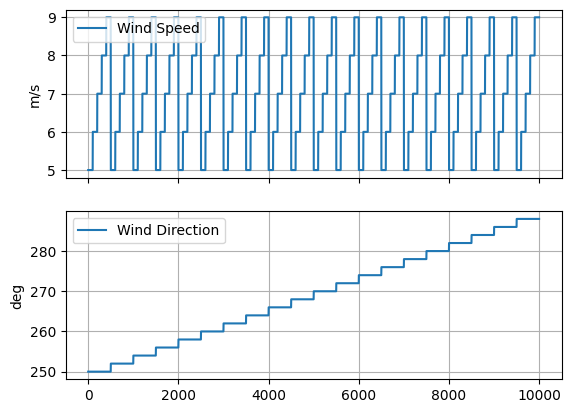

In [8]:
# Create a time history of points where the wind speed and wind
# direction step different combinations
ws_points = np.arange(5.0, 10.0, 1.0)
wd_points = np.arange(
    250.0,
    290.0,
    2,
)
num_points_per_combination = 10 * points_per_group  # How many "seconds" per combination

# I know this is dumb but will come back, can't quite work out the numpy version
wd_array = []
ws_array = []
for wd in wd_points:
    for ws in ws_points:
        for i in range(num_points_per_combination):
            ws_array.append(ws)
            wd_array.append(wd)
t = np.arange(len(ws_array))

print(f"Num Points {len(t)}")

fig, axarr = plt.subplots(2, 1, sharex=True)
axarr[0].plot(t, ws_array, label="Wind Speed")
axarr[0].set_ylabel("m/s")
axarr[0].legend()
axarr[0].grid(True)
axarr[1].plot(t, wd_array, label="Wind Direction")
axarr[1].set_ylabel("deg")
axarr[1].legend()
axarr[1].grid(True)

In [9]:
total_number_of_points = len(ws_array)
total_number_of_points

10000

# Simulate benchmark FLORIS and save power in kW

In [10]:
# Compute the power of the second turbine for two cases
# Baseline: The front turbine is aligned to the wind
# WakeSteering: The front turbine is yawed 25 deg
fm_benchmark.set(
    wind_speeds=ws_array,
    wind_directions=wd_array,
    turbulence_intensities=0.06 * np.ones_like(ws_array),
)
fm_benchmark.run()
power_baseline = fm_benchmark.get_turbine_powers().squeeze() / 1000.0

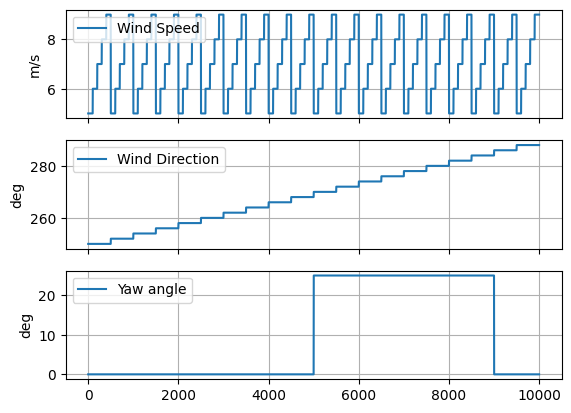

In [11]:
# Set up yaw angles to be positive for winds over 250
yaw_angles = np.zeros([len(ws_array), num_turbines])
yaw_angles[
    ((np.array(wd_array) >= 270) & (np.array(wd_array) <= 285)), control_idx
] = 25  # Set control turbine yaw angles to 25 deg

fig, axarr = plt.subplots(3, 1, sharex=True)
axarr[0].plot(t, ws_array, label="Wind Speed")
axarr[0].set_ylabel("m/s")
axarr[0].legend()
axarr[0].grid(True)
axarr[1].plot(t, wd_array, label="Wind Direction")
axarr[1].set_ylabel("deg")
axarr[1].legend()
axarr[1].grid(True)
axarr[2].plot(t, yaw_angles[:, control_idx], label="Yaw angle")
axarr[2].set_ylabel("deg")
axarr[2].legend()
axarr[2].grid(True)

In [12]:
fm_benchmark.set(yaw_angles=yaw_angles)
fm_benchmark.run()
power_wakesteering = fm_benchmark.get_turbine_powers().squeeze() / 1000.0

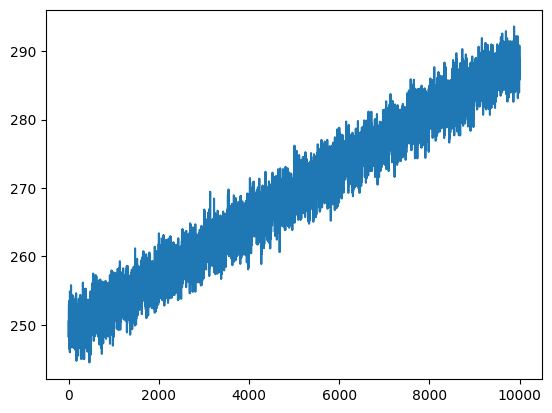

In [13]:
# Recompute assuming some random perturbation of the wd signal
wd_std_benchmark = 2.0
wd_array_noisy = (wd_array + np.random.randn(len(wd_array)) * wd_std_benchmark,)
wd_array_noisy = wd_array_noisy[0]
plt.plot(wd_array_noisy)

In [14]:
fm_benchmark.set(
    wind_speeds=ws_array,
    wind_directions=wd_array_noisy,
    turbulence_intensities=0.06 * np.ones_like(ws_array),
)
fm_benchmark.run()
power_baseline_noisy = fm_benchmark.get_turbine_powers().squeeze() / 1000.0


fm_benchmark.set(yaw_angles=yaw_angles)
fm_benchmark.run()
power_wakesteering_noisy = fm_benchmark.get_turbine_powers().squeeze() / 1000.0

## Assemble the data into pandas dataframes

In [15]:
def get_df(data, wd_, ws_):
    # Define the power column names
    pow_cols = ["pow_%03d" % t for t in range(num_turbines)]

    # Build the dataframe
    df_ = pd.DataFrame(data=data, columns=pow_cols)

    # Add ws and wd and pow_ref
    df_ = df_.assign(
        wd=wd_,  # + np.random.randn(len(wd_array))* wd_noise,
        ws=ws_,  # + np.random.randn(len(ws_array))* ws_noise
    )

    # Aggregate every 10 points together
    df_["group"] = df_.index // points_per_group

    # Group the DataFrame by the 'group' column and calculate the mean
    df_ = df_.groupby("group").agg("mean")

    # Reset the index to have a clean index
    df_ = df_.reset_index(drop=True)
    # df_['pow_ref'] = df_['pow_%03d' % ref_idx]

    # Reorganize columns

    df_ = df_[["wd", "ws"] + pow_cols]

    return df_

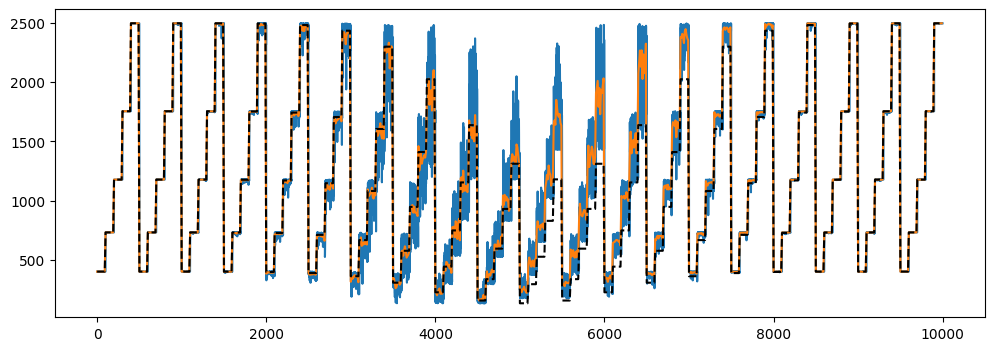

In [16]:
df_baseline = get_df(power_baseline, wd_array, ws_array)
df_wakesteering = get_df(power_wakesteering, wd_array, ws_array)
df_baseline_noisy = get_df(power_baseline_noisy, wd_array_noisy, ws_array)
df_wakesteering_noisy = get_df(power_wakesteering_noisy, wd_array_noisy, ws_array)
# df_wakesteering = get_df(power_wakesteering)

# # Get noisy versions
# df_baseline_noisy = get_df(power_baseline, wd_noise=2., ws_noise=0.)
# df_wakesteering_noisy = get_df(power_wakesteering, wd_noise=2., ws_noise=0.)

n_row = power_baseline.shape[0]
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(list(range(n_row)), power_baseline_noisy[:, single_wake_idx])
ax.plot(np.arange(0, n_row, 10), df_baseline_noisy["pow_%03d" % single_wake_idx])
ax.plot(np.arange(0, n_row, 10), df_baseline["pow_%03d" % single_wake_idx], "k--")

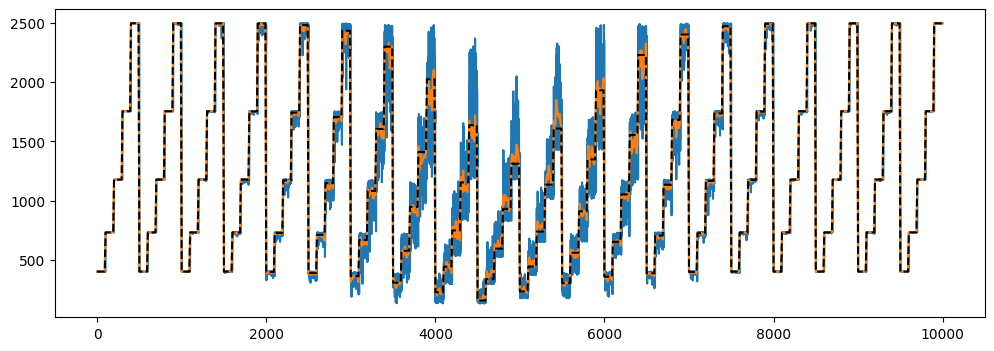

In [17]:
n_row = power_baseline.shape[0]
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(list(range(n_row)), power_wakesteering_noisy[:, single_wake_idx])
ax.plot(np.arange(0, n_row, 10), df_wakesteering_noisy["pow_%03d" % single_wake_idx])
ax.plot(np.arange(0, n_row, 10), df_wakesteering["pow_%03d" % single_wake_idx], "k--")

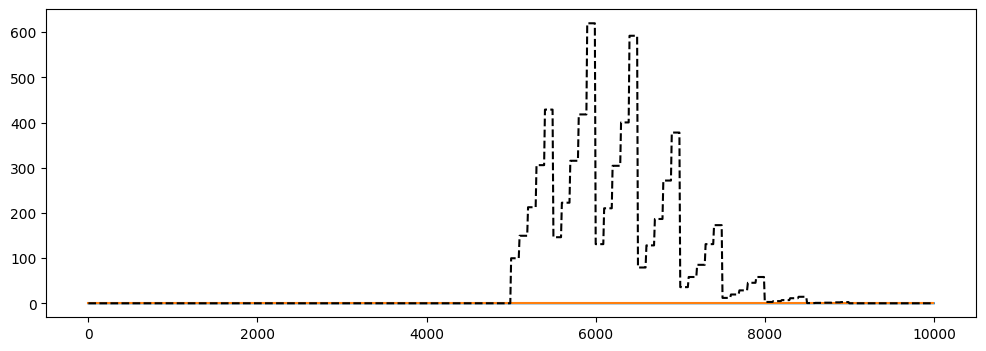

In [18]:
n_row = power_baseline.shape[0]
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    list(range(n_row)),
    power_wakesteering_noisy[:, single_wake_idx] - power_baseline_noisy[:, single_wake_idx],
)
ax.plot(
    np.arange(0, n_row, 10),
    df_wakesteering_noisy["pow_%03d" % single_wake_idx]
    - df_baseline_noisy["pow_%03d" % single_wake_idx],
)
ax.plot(
    np.arange(0, n_row, 10),
    df_wakesteering["pow_%03d" % single_wake_idx] - df_baseline["pow_%03d" % single_wake_idx],
    "k--",
)

In [19]:
# Similarly average the yaw angle matrices along every 10
yaw_angles_reshaped = yaw_angles.reshape(
    total_number_of_points // points_per_group, points_per_group, yaw_angles.shape[1]
)
yaw_angles = np.mean(yaw_angles_reshaped, axis=1)

In [20]:
# Save the yaw angles
yaw_angles_base = 0 * yaw_angles
yaw_angels_wakesteering = yaw_angles

## Tune Wake Expansion (First Index) to baseline (non-noisy) data

In [21]:
wake_expansion_rates = np.arange(start=0.010, stop=0.050, step=0.001)

In [22]:
df_scada = df_baseline.copy()
floris_wake_losses, scada_wake_loss = ft.sweep_velocity_model_parameter_for_overall_wake_losses(
    parameter=["wake", "wake_velocity_parameters", "empirical_gauss", "wake_expansion_rates"],
    value_candidates=wake_expansion_rates,
    df_scada_in=df_scada,
    fm_in=fm_emg,
    param_idx=0,
    ref_turbines=[ref_idx],
    test_turbines=[single_wake_idx],
)
print(floris_wake_losses, scada_wake_loss)

[16.49475351 16.32929173 16.16761604 16.00982212 15.84299221 15.67823304
 15.51752308 15.35646901 15.19782758 15.03868464 14.87974144 14.72281613
 14.5682697  14.41617994 14.26546445 14.11709457 13.97165818 13.82976913
 13.69041331 13.55314438 13.41630418 13.28081246 13.14841388 13.01886068
 12.89154384 12.76397048 12.6374796  12.51256951 12.38920503 12.26796275
 12.14553334 12.02512474 11.90695745 11.79161179 11.67724949 11.56302711
 11.45080725 11.34117785 11.23375237 11.12797132] 14.416179942373729


Text(0, 0.5, 'Percent Wake Loss')

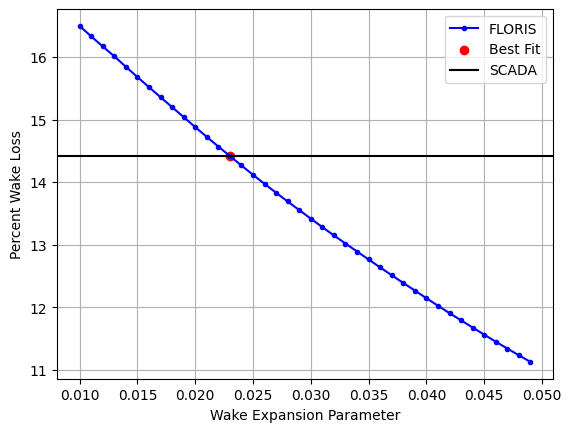

In [23]:
fig, ax = plt.subplots()
best_param = ft.select_best_wake_model_parameter(
    floris_wake_losses, scada_wake_loss, wake_expansion_rates, ax=ax
)
ax.set_xlabel("Wake Expansion Parameter")
ax.set_ylabel("Percent Wake Loss")

In [24]:
# Apply the best fit
fm_emg.set_param(
    ["wake", "wake_velocity_parameters", "empirical_gauss", "wake_expansion_rates"],
    param_idx=0,
    value=best_param,
)

In [25]:
print(
    fm_emg.core.as_dict()["wake"]["wake_velocity_parameters"]["empirical_gauss"][
        "wake_expansion_rates"
    ]
)

[0.02299999999999999, 0.008]


## Retune with noisy data

In [26]:
# Make a copy for the noisy fi_emg model
fm_emg_noisy = fm_emg.copy()

In [27]:
print(
    fm_emg_noisy.core.as_dict()["wake"]["wake_velocity_parameters"]["empirical_gauss"][
        "wake_expansion_rates"
    ]
)

[0.02299999999999999, 0.008]


In [28]:
df_scada = df_baseline_noisy.copy()
floris_wake_losses, scada_wake_loss = ft.sweep_velocity_model_parameter_for_overall_wake_losses(
    parameter=["wake", "wake_velocity_parameters", "empirical_gauss", "wake_expansion_rates"],
    value_candidates=wake_expansion_rates,
    df_scada_in=df_scada,
    fm_in=fm_emg_noisy,
    param_idx=0,
    ref_turbines=[ref_idx],
    test_turbines=[single_wake_idx],
)
print(floris_wake_losses, scada_wake_loss)

[16.6960671  16.52400188 16.35428625 16.18545166 16.01653141 15.84925653
 15.68275445 15.51407021 15.34795293 15.18387463 15.01945228 14.85767882
 14.69896071 14.54305927 14.38819389 14.23591862 14.08627611 13.9393262
 13.7948687  13.65301899 13.51343357 13.37578583 13.24043917 13.10677324
 12.97459477 12.84386487 12.71533457 12.58885784 12.46367617 12.33903225
 12.21578221 12.09446953 11.9747595  11.85644452 11.73876261 11.62300939
 11.509029   11.39691835 11.28652436 11.17800826] 10.010879157904723


Text(0, 0.5, 'Percent Wake Loss')

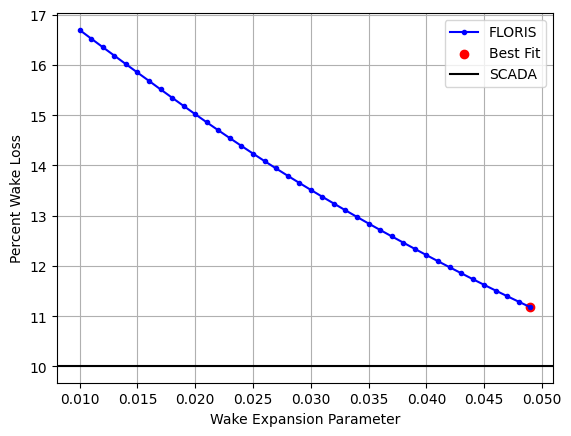

In [29]:
fig, ax = plt.subplots()
best_param = ft.select_best_wake_model_parameter(
    floris_wake_losses, scada_wake_loss, wake_expansion_rates, ax=ax
)
ax.set_xlabel("Wake Expansion Parameter")
ax.set_ylabel("Percent Wake Loss")

In [30]:
# Apply the best fit
fm_emg_noisy.set_param(
    ["wake", "wake_velocity_parameters", "empirical_gauss", "wake_expansion_rates"],
    param_idx=0,
    value=best_param,
)

## Identify wd_std

In [31]:
min_wd = np.floor(np.min([df_baseline.wd.min(), df_baseline_noisy.wd.min()]))
max_wd = np.ceil(np.max([df_baseline.wd.max(), df_baseline_noisy.wd.max()]))

min_ws = np.floor(np.min([df_baseline.ws.min(), df_baseline_noisy.ws.min()]))
max_ws = np.ceil(np.max([df_baseline.ws.max(), df_baseline_noisy.ws.max()]))

In [32]:
# Make approximate tables
wd_array = np.arange(min_wd, max_wd, 1.0)
ws_array = np.arange(min_ws, max_ws, 1.0)

df_approx = ftools.calc_floris_approx_table(
    fm_emg, wd_array=wd_array, ws_array=ws_array, ti_array=np.array([0.1])
)

Generating a df_approx table of FLORIS solutions covering a total of 168 cases.
Finished calculating the FLORIS solutions for the dataframe.


In [33]:
df_approx_noisy = ftools.calc_floris_approx_table(
    fm_emg_noisy, wd_array=wd_array, ws_array=ws_array, ti_array=np.array([0.1])
)

Generating a df_approx table of FLORIS solutions covering a total of 168 cases.
Finished calculating the FLORIS solutions for the dataframe.


In [34]:
# Select the values to check
wd_std_range = [0, 1, 2, 3, 4, 5]

In [35]:
# Evaluate
df_scada = df_baseline.copy()
er_error, df_list = ft.sweep_wd_std_for_er(
    wd_std_range, df_scada, df_approx, ref_turbines=[ref_idx], test_turbines=[single_wake_idx]
)

Identified the following grid type: 2d.
   minimum/maximum value in df:        (5.000, 9.000)
   minimum/maximum value in df_approx: (5.000, 8.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with interpolation method 'linear'.
     Interpolating pow for all turbines...
Finished interpolation in 0.001 seconds.
Identified the following grid type: 2d.
   minimum/maximum value in df:        (5.000, 9.000)
   minimum/maximum value in df_approx: (5.000, 8.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with interpolation method 'linear'.
     Interpolating pow for all turbines...
Finished interpolation in 0.001 seconds.
Identified the following grid type: 2d.
   minimum/maximum value in df:        (5.000, 9.000)
   minimum/maximum value in df_approx: (5.000, 8.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with interpol

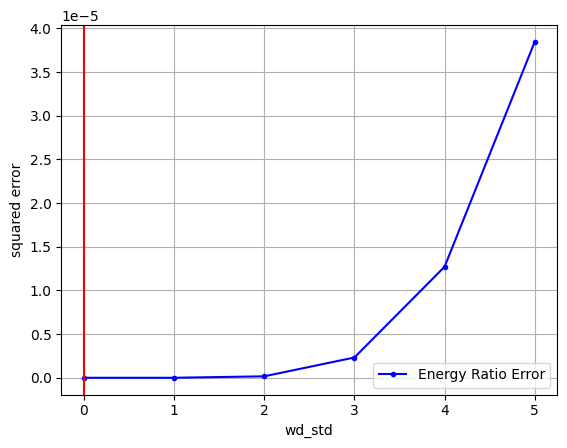

In [36]:
# Select the best result
fig, ax = plt.subplots()
best_param = ft.select_best_wd_std(er_error, wd_std_range, ax=ax)

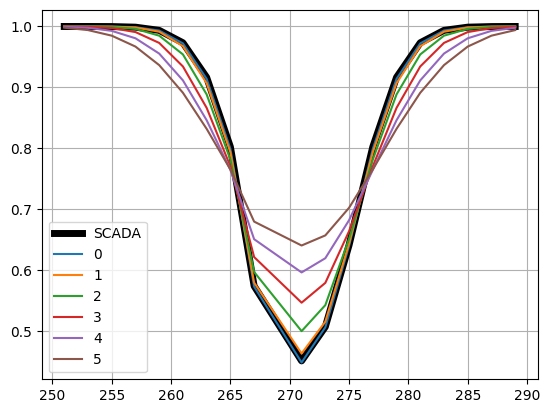

In [37]:
# Plot the values
fig, ax = plt.subplots()

ax.plot(df_list[0]["wd_bin"], df_list[0]["SCADA"].values, color="k", lw=5, label="SCADA")

for i, wd_std in enumerate(wd_std_range):
    ax.plot(df_list[i]["wd_bin"], df_list[i]["FLORIS"].values, label=wd_std)

ax.grid()
ax.legend()

#### Repeat with noisy data

In [38]:
df_scada = df_baseline_noisy.copy()
er_error, df_list = ft.sweep_wd_std_for_er(
    wd_std_range, df_scada, df_approx_noisy, ref_turbines=[ref_idx], test_turbines=[single_wake_idx]
)

Identified the following grid type: 2d.
   minimum/maximum value in df:        (248.961, 289.453)
   minimum/maximum value in df_approx: (248.000, 289.000)
   minimum/maximum value in df:        (5.000, 9.000)
   minimum/maximum value in df_approx: (5.000, 8.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with interpolation method 'linear'.
     Interpolating pow for all turbines...
Finished interpolation in 0.003 seconds.
Identified the following grid type: 2d.
   minimum/maximum value in df:        (248.961, 289.453)
   minimum/maximum value in df_approx: (248.000, 289.000)
   minimum/maximum value in df:        (5.000, 9.000)
   minimum/maximum value in df_approx: (5.000, 8.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with interpolation method 'linear'.
     Interpolating pow for all turbines...
Finished interpolation in 0.001 seconds.
Identified the following grid 

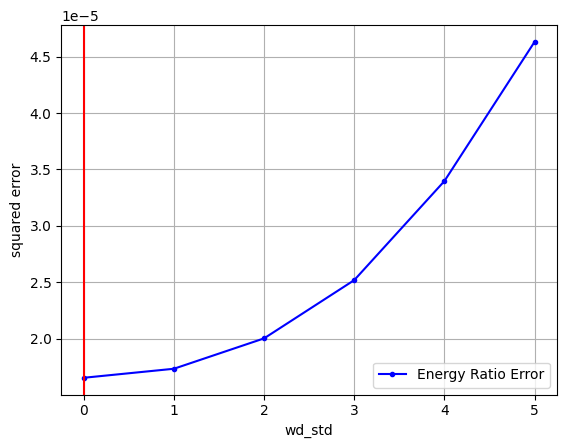

In [39]:
# Select the best result
fig, ax = plt.subplots()
best_param = ft.select_best_wd_std(er_error, wd_std_range, ax=ax)

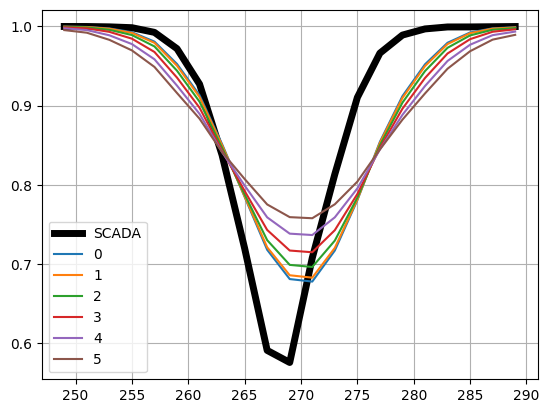

In [40]:
# Plot the values
fig, ax = plt.subplots()

ax.plot(df_list[0]["wd_bin"], df_list[0]["SCADA"].values, color="k", lw=5, label="SCADA")

for i, wd_std in enumerate(wd_std_range):
    ax.plot(df_list[i]["wd_bin"], df_list[i]["FLORIS"].values, label=wd_std)

ax.grid()
ax.legend()

## Tune deflection

In [41]:
hor_def_gains = np.arange(start=0.0, stop=5, step=0.2)

In [42]:
floris_uplifts, scada_uplift = ft.sweep_deflection_parameter_for_total_uplift(
    parameter=[
        "wake",
        "wake_deflection_parameters",
        "empirical_gauss",
        "horizontal_deflection_gain_D",
    ],
    value_candidates=hor_def_gains,
    df_scada_baseline_in=df_baseline,
    df_scada_wakesteering_in=df_wakesteering,
    fm_in=fm_emg,
    ref_turbines=[ref_idx],
    test_turbines=[single_wake_idx],
    yaw_angles_wakesteering=yaw_angles,
)

In [43]:
floris_uplifts, scada_uplift

(array([2.3620752 , 2.58036597, 2.79926482, 3.01823547, 3.23910144,
        3.4610657 , 3.68223937, 3.90339759, 4.12402072, 4.34194854,
        4.5586649 , 4.77471308, 4.98895207, 5.19935324, 5.40542043,
        5.60677409, 5.80608574, 5.99994176, 6.18834151, 6.37196041,
        6.55081939, 6.72304104, 6.89010967, 7.05255549, 7.20769755]),
 5.606774094970125)

Text(0, 0.5, 'Percent Uplift')

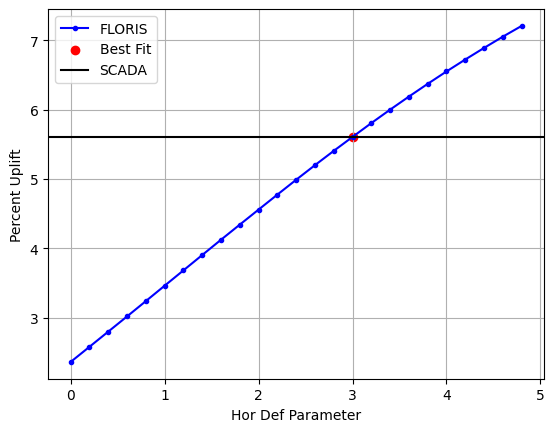

In [44]:
fig, ax = plt.subplots()
best_param = ft.select_best_wake_model_parameter(floris_uplifts, scada_uplift, hor_def_gains, ax=ax)
ax.set_xlabel("Hor Def Parameter")
ax.set_ylabel("Percent Uplift")

Small uplift in power at downstream turbine even with 0 wake deflection because effective axial induction factor at upstream turbine is reduced by yaw misalignment

In [45]:
## Repeat for noisy
floris_uplifts, scada_uplift = ft.sweep_deflection_parameter_for_total_uplift(
    parameter=[
        "wake",
        "wake_deflection_parameters",
        "empirical_gauss",
        "horizontal_deflection_gain_D",
    ],
    value_candidates=hor_def_gains,
    df_scada_baseline_in=df_baseline_noisy,
    df_scada_wakesteering_in=df_wakesteering_noisy,
    fm_in=fm_emg_noisy,
    ref_turbines=[ref_idx],
    test_turbines=[single_wake_idx],
    yaw_angles_wakesteering=yaw_angles,
)

Text(0, 0.5, 'Percent Uplift')

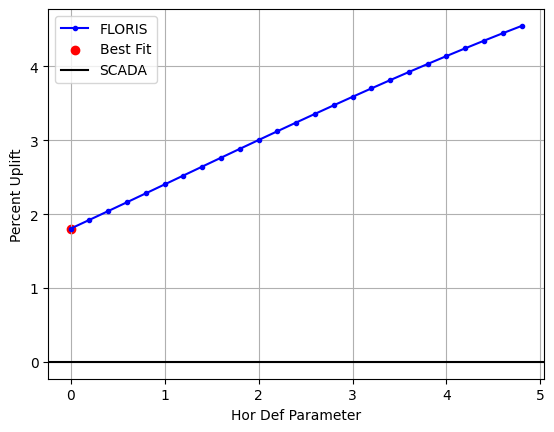

In [46]:
fig, ax = plt.subplots()
best_param = ft.select_best_wake_model_parameter(floris_uplifts, scada_uplift, hor_def_gains, ax=ax)
ax.set_xlabel("Hor Def Parameter")
ax.set_ylabel("Percent Uplift")